In [49]:
# imports
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pylab as plt
import math
# reading the data 
data = pd.read_csv('../data/prices.txt',  sep=',', index_col="Date")

# define the columns names
# data.columns = ["Date","Price"]
data.index = pd.to_datetime(data.index)

In [50]:
# data['Date'] = pd.to_datetime(data['Date'])
# data['year']=data['Date'].dt.year

In [51]:
# data['year'].value_counts()

## Data validation 

In [52]:
# check if there is a null values
data.isnull().values.any()

False

In [53]:
# check the number of nulls if found 
data.isnull().sum().sum()

0

In [54]:
data.sort_values(by="Date",inplace=True)

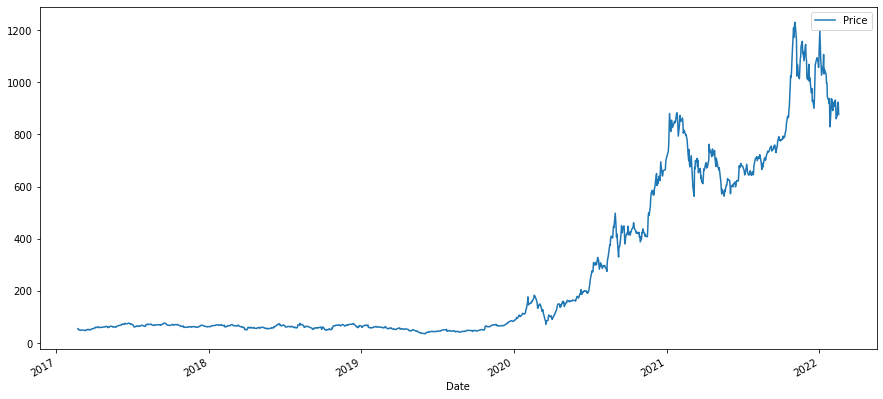

In [55]:
data.plot(style='-',figsize=(15,7))
plt.show()

In [56]:
data.index.min()

Timestamp('2017-02-21 00:00:00')

In [57]:
data.index.max()

Timestamp('2022-02-17 00:00:00')

## feature engineering

In [58]:
# 

def create_features(data):
    """
    Creates time series features from datetime index
    """
    # convert data column to datetime which will make it easy to dealing with time data
    data['Date_'] = data.index
    data['Date_'] = pd.to_datetime(data['Date_'])
    data['Date_'] = pd.to_datetime(data['Date_'],format='%m/%d/%Y')
    data['year']=data['Date_'].dt.year 
    data['month']=data['Date_'].dt.month 
    data['day']=data['Date_'].dt.day
    data['dayofweek']=data['Date_'].dt.dayofweek  
    data.drop("Date_",axis=1,inplace=True)
    
    # adding more features using by shift the columns
    data['lag_1'] = data['Price'].shift(1)
    data['lag_2'] = data['Price'].shift(2)
    data['lag_3'] = data['Price'].shift(3)
    data['lag_4'] = data['Price'].shift(4)
    data['lag_5'] = data['Price'].shift(5)
    data['lag_6'] = data['Price'].shift(6)
    data['lag_7'] = data['Price'].shift(7)

    #adding multiple features using rolling window
    data['rolling_mean_2'] = data['Price'].rolling(window=2).mean()
    data['rolling_mean_3'] = data['Price'].rolling(window=3).mean()
    data['rolling_mean_4'] = data['Price'].rolling(window=4).mean()
    data['rolling_mean_5'] = data['Price'].rolling(window=5).mean()
    data['rolling_mean_6'] = data['Price'].rolling(window=6).mean()
    data['rolling_mean_7'] = data['Price'].rolling(window=7).mean()

    #adding addional features using expanding window
    data['expanding_mean'] = data['Price'].expanding(2).mean()
    data['expanding_mean'] = data['Price'].expanding(3).mean()
    data['expanding_mean'] = data['Price'].expanding(4).mean()
    data['expanding_mean'] = data['Price'].expanding(5).mean()
    data['expanding_mean'] = data['Price'].expanding(6).mean()
    data['expanding_mean'] = data['Price'].expanding(7).mean()
    
    label = "Price"
    features = [col for col in data.columns if col!= label]
    
    x = data[features]
    y = data[label]  

    return x,y

## Data Train-test split

In [59]:
# split the data to train and test
split = int(len(data) * 0.80)

train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

X_train, y_train = create_features(train)
X_test, y_test = create_features(test)


In [60]:
X_train["year"].min()

2017

In [61]:
X_train["year"].max()

2021

In [62]:
X_test["year"].min()

2021

In [63]:
X_test["year"].max()

2022

In [64]:
print(X_train.shape)
print(X_test.shape)

(1007, 18)
(252, 18)


## Model Training(Xgboost) 

In [65]:
# XGBRegressor treat nulls as zeros
reg = xgb.XGBRegressor()

In [66]:
reg.fit(X_train, y_train,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

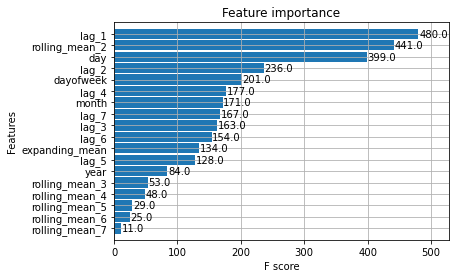

In [67]:
plot_importance(reg, height=0.9)

In [68]:
test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([test, train], sort=False)

<AxesSubplot:xlabel='Date'>

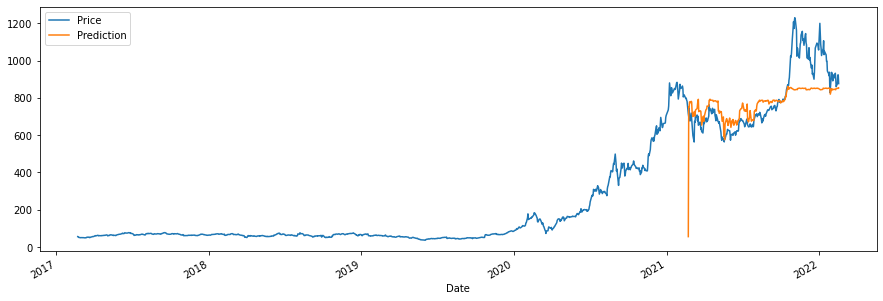

In [69]:
data_all[['Price','Prediction']].plot(figsize=(15, 5), style=['-','-'])

In [70]:
## Model evaluation 

In [71]:
# evalaute the model 
def evaluate(y_true, y_pred):
    results = {'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred),
            'MAPE':mean_absolute_percentage_error(y_true, y_pred)}
    return results

In [72]:
evaluate(test['Price'],test['Prediction'])

{'MAE': 97.39427569545008,
 'MSE': 17685.122794403058,
 'RMSE': 132.985423240305,
 'R2': 0.42532012479650017,
 'MAPE': 0.11332535386818121}

## Explore Seasonality

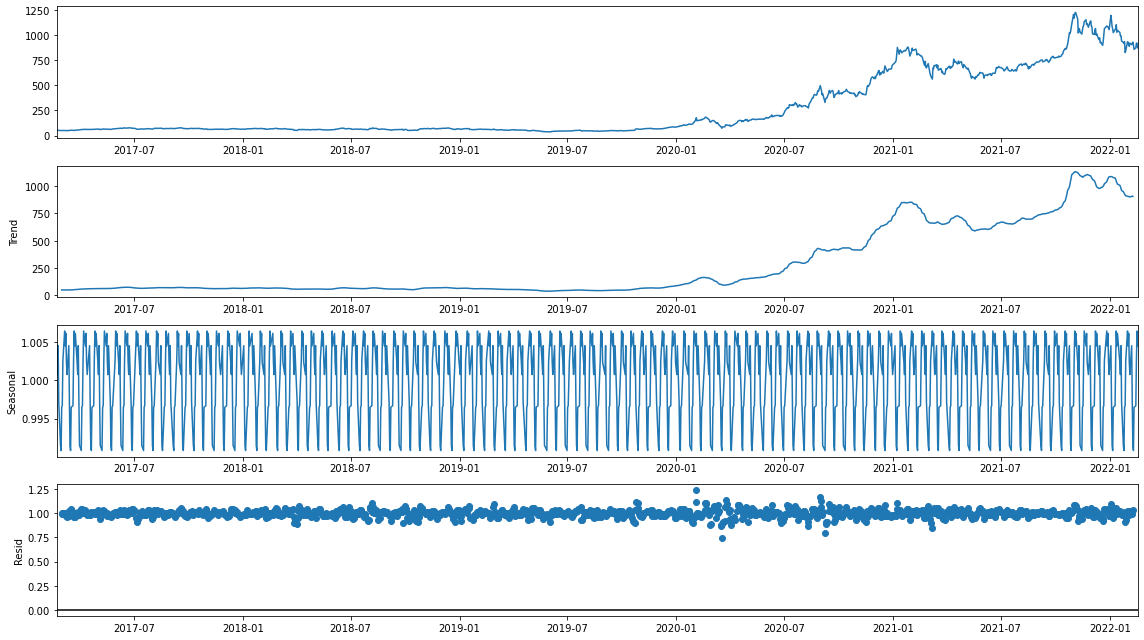

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

data = pd.read_csv('../data/prices.txt',  sep=',')

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
analysis = data[['Price']].copy()

decompose_result_mult = seasonal_decompose(analysis, model="multiplicative",period=12)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid


fig = decompose_result_mult.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
# plt.show()

## Prophet

In [77]:
# IMPORTS
from fbprophet import Prophet 
# reading data
data = pd.read_csv('../data/prices.txt',  sep=',')
# rename columns to ds and y because prophet expect these two columns with the same name
data.columns = ['ds','y']
data['ds'] = pd.to_datetime(data['ds'])

In [78]:
# split the data to train and test
split = int(len(data) * 0.80)

train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [79]:
# define and fit prophet model
model=Prophet(daily_seasonality=True)
model.fit(train)

In [80]:
# predict the test set.
# the ouput will be a dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.
prediction=model.predict(test)

In [81]:
evaluate(test['y'], prediction['yhat'])

{'MAE': 420.0043168632662,
 'MSE': 200259.91068401193,
 'RMSE': 447.5040901310422,
 'R2': -5.507466293452818,
 'MAPE': 0.5435561309045834}

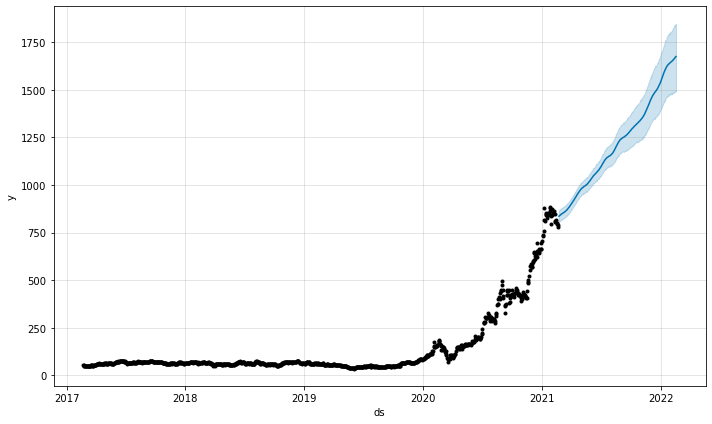

In [82]:
# plot the predictions
model.plot(prediction)
plt.show()

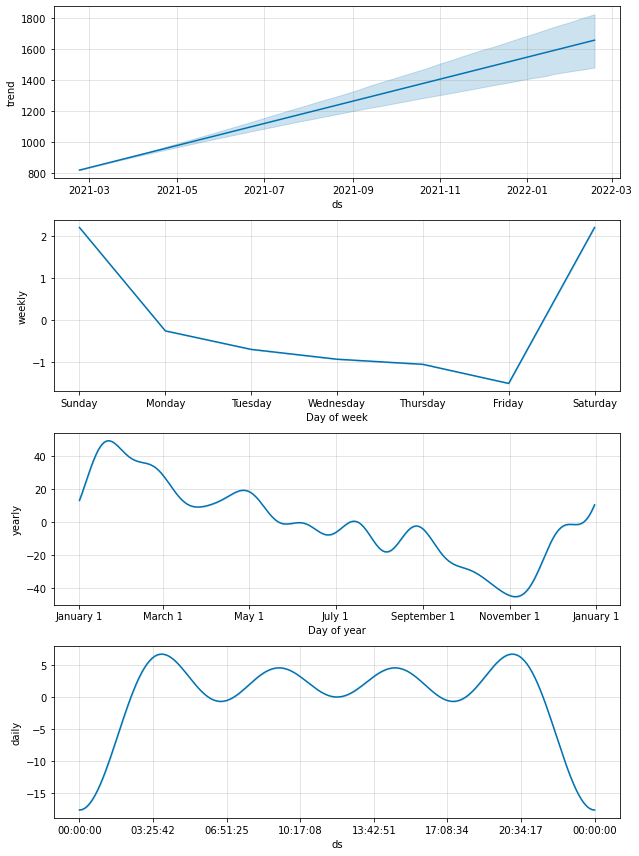

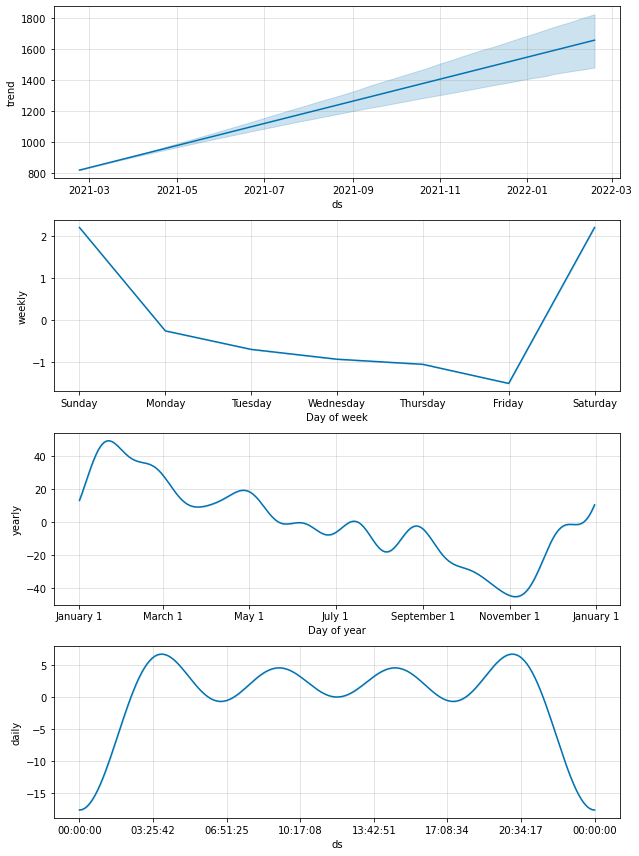

In [83]:
# plot the componnets of prophet model (trend, holidays, weekly seasonality, yearly seasonality, and additive and multiplicative extra regressors)
model.plot_components(prediction)